### Problem 5 and 6

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

In [2]:
# Get data
raw_data = pd.read_csv('insurance.csv')
# Divide samples into training and test sets
train_samples = np.random.rand(len(raw_data)) < 0.8
train_data = raw_data[train_samples]
test_data = raw_data[~train_samples]

# Preprocess data
x = train_data[['age', 'bmi', 'children']]
x = (x - x.mean()) / x.std()
y = train_data['charges']
y = (y - y.mean()) / y.std()


test_x = test_data[['age', 'bmi', 'children']]
test_x = (test_x - test_x.mean()) / test_x.std()
test_y = test_data['charges']
test_y = (test_y - test_y.mean()) / test_y.std()

In [3]:
# Define hyperparameters
sig_alpha = 1.
tau0, tau1 = 3., 0.5
cov_beta = np.array([
    [1., 0., 0.],
    [0., 1., 0.],
    [0., 0., 1.],
])
# Number of samples for predictive distribution
num_samples = 1000
data = {
    'N': x.shape[0],
    'x': x.to_numpy(),
    'y': y.to_numpy(),
    'tau0': tau0,
    'tau1': tau1,
    'cov_beta': cov_beta,
    'sigma_alpha': sig_alpha,
    'M': test_x.shape[0],
    'test_x': test_x.to_numpy(),
    'test_y': test_y.to_numpy(),
    'S': num_samples,
}

In [4]:
regression_code = '''
data {
    int<lower=1> N;
    array[N, 3] real x;
    array[N] real y;
    real sigma_alpha;
    real tau0;
    real tau1;
    matrix[3, 3] cov_beta;
    int<lower=1> M;
    array[M, 3] real test_x;
    array[M] real test_y;
    int<lower=1> S;
}
parameters {
    real sigma_sqr;
    real alpha;
    vector[3] beta;
}
transformed parameters {
    real sigma;
    sigma = sqrt(sigma_sqr);
}
model {
    // Priors
    sigma_sqr ~ inv_gamma(tau0, tau1);
    alpha ~ normal(0, sigma_alpha);
    beta ~ multi_normal(rep_vector(0, 3), cov_beta);

    // Regression
    for (n in 1:N) {
        y[n] ~ normal(alpha + to_row_vector(beta) * to_vector(x[n]), sigma);
    }
}

generated quantities {
  array[M] real sample_means;
  array[S] real samples;
  
  for (m in 1:M) {
    // Generate S samples from the m'th test sample 
    samples = normal_rng(rep_vector(alpha + to_row_vector(beta) * to_vector(test_x[m]), S), sigma);
    
    // Take the mean to compute predictive mean
    sample_means[m] = mean(samples);
  }
}
'''

In [5]:
model = stan.build(regression_code, data=data)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_jyszhlee/model_7wyyuuj3.stan', line 26, column 4: Parameter
    sigma_sqr is given a inv_gamma distribution, which has strictly positive
    support, but sigma_sqr was not constrained to be strictly positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [6]:
fit = model.sample(num_chains=4, num_warmup=1000, num_samples=2500)

Sampling:   0%
Sampling:   1% (200/14000)
Sampling:   3% (400/14000)
Sampling:   4% (600/14000)
Sampling:   6% (800/14000)
Sampling:   9% (1200/14000)
Sampling:  11% (1600/14000)
Sampling:  15% (2100/14000)
Sampling:  18% (2500/14000)
Sampling:  21% (2901/14000)
Sampling:  24% (3302/14000)
Sampling:  26% (3603/14000)
Sampling:  29% (4004/14000)
Sampling:  29% (4103/14000)
Sampling:  30% (4202/14000)
Sampling:  31% (4301/14000)
Sampling:  31% (4400/14000)
Sampling:  32% (4500/14000)
Sampling:  33% (4600/14000)
Sampling:  34% (4700/14000)
Sampling:  34% (4800/14000)
Sampling:  35% (4900/14000)
Sampling:  36% (5000/14000)
Sampling:  36% (5100/14000)
Sampling:  37% (5200/14000)
Sampling:  38% (5300/14000)
Sampling:  39% (5400/14000)
Sampling:  39% (5500/14000)
Sampling:  40% (5600/14000)
Sampling:  41% (5700/14000)
Sampling:  41% (5800/14000)
Sampling:  42% (5900/14000)
Sampling:  43% (6000/14000)
Sampling:  44% (6100/14000)
Sampling:  44% (6200/14000)
Sampling:  45% (6300/14000)
Sampling:

In [7]:
res = az.summary(fit)

In [8]:
# Regresed parameters
param_res = res.iloc[0:6]
# generated samples
preds = res.iloc[6:]

In [9]:
predictive_means = preds[:test_y.shape[0]]['mean'].to_numpy() # predictive means 

### RMSE between $\hat{y}_{m}$ and $y_{m}$

In [10]:
# RMSE between predictive means to respective test sample
rmse = np.sqrt( np.sum( np.square(predictive_means - test_y) ) / predictive_means.shape[0] )
rmse

0.9361244359969729

In [11]:
param_res

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_sqr,0.882,0.039,0.812,0.959,0.0,0.0,13909.0,6859.0,1.0
alpha,0.000,0.028,-0.054,0.054,0.0,0.0,13030.0,7533.0,1.0
beta[0],0.277,0.029,0.222,0.332,0.0,0.0,12245.0,7408.0,1.0
beta[1],0.168,0.029,0.117,0.223,0.0,0.0,12593.0,8194.0,1.0
beta[2],0.037,0.029,-0.018,0.091,0.0,0.0,13075.0,7679.0,1.0
sigma,0.939,0.021,0.901,0.979,0.0,0.0,13909.0,6859.0,1.0


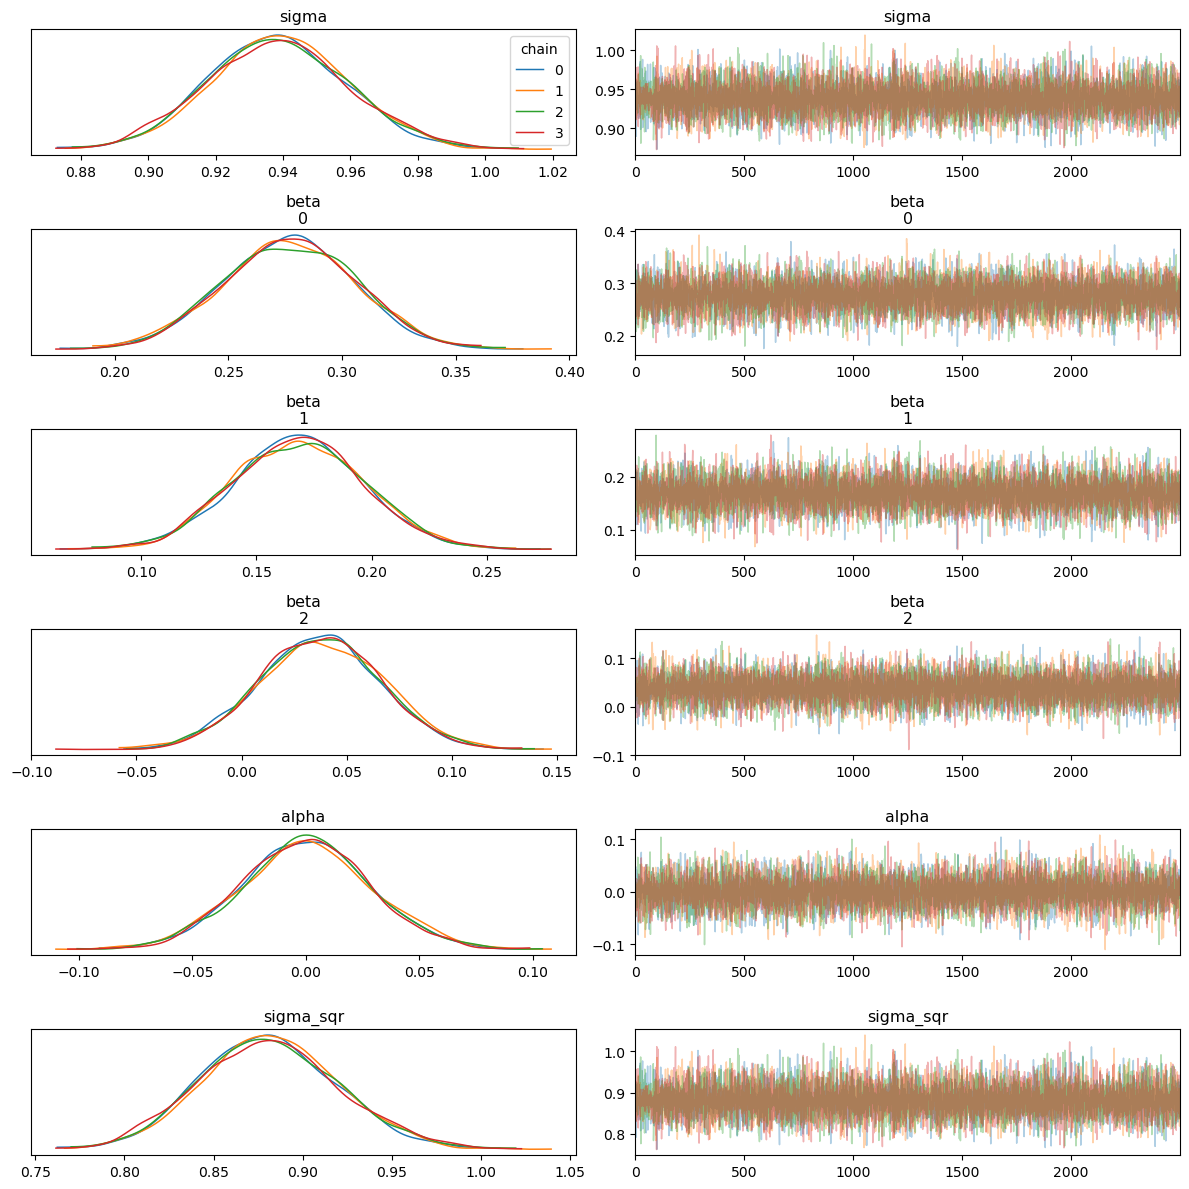

In [12]:
f = az.plot_trace(fit, var_names=['sigma', 'beta', 'alpha', 'sigma_sqr'], compact=False, legend=True)
plt.tight_layout()